## Test Bench
This  notebook is used to evaluate the performance of a compression algorithm.

It is written such that a new compression algorithm can be added without altering the bench (just change the input in the config).

In [1]:
# ADD NEW ALGORITHMS HERE
from algos.alg_wkt import Wkt
from algos.alg_wkb import Wkb
from algos.alg_meta_wkb_comp import MetaWkbComp # Wkb with Metadat
from algos.alg_meta_wkt_comp import MetaWktComp # Wkt with Metadat
from algos.alg_wkb_comp import WkbComp
from algos.alg_wkt_comp import WktComp
from algos.alg_fpd import Fpd
from algos.alg_fpd_extended import FpdExtended
from algos.alg_fpd_predictor import FpdPredictor
from algos.fpd_extended_lib.entropy_coder import *


# CONFIG
ALG = FpdExtended()
DATASET_PATH = "data/lund_building_highway.json"
#DATASET_PATH = "data/sweden_processed_whole"
#DATASET_PATH = "data/world.json"
DATASET_PATH = "data/world_7_dec.json"
#DATASET_PATH = "data/sweden.json"
#DATASET_PATH = "data/latest_export.json"
#DATASET_PATH = "data/latest_export" # Use folder (single files)
NBR_ITER = 1000
AVOID_DATASET_LENGTH_CHECK = False # For very large folders, disable

IS_SHP_DIR = False
#DATASET_PATH = "data/sweden-latest-free"
DATASET_PATH = 'data/china-latest-free/gis_osm_water_a_free_1.shp'
# Used sets: ["data/sweden-latest-free/gis_osm_buildings_a_free_1.shp", "data/sweden-latest-free/gis_osm_roads_free_1.shp", "data/china-latest-free/gis_osm_water_a_free_1.shp", "data/ne_10m_admin_1_states_provinces.shp"]

COMPR_PATH = "data/testbench_compressed_single"
#COMPR_PATH = "data/testbench_compressed"

DECOMPR_PATH = "data/testbench_decompressed_single"

In [2]:
import time
import os
from enum import Enum
import pandas as pd
from datetime import datetime
import filecmp
import random
import json
import tqdm
from shapely.geometry import shape
import glob
import timeit
import shapely
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

# List the metrics which are to be logged
ET = Enum('ET', ['COMP_TIME', 'DECOMP_TIME', 'COMP_SIZE', 'DECOMP_SIZE',
    'VERTICES', 'TYPE', 'BOUNDING_BOX', 'ADD_VERTEX', 'IS_INTERSECTING', 'INTERSECTION'
]) # EVAL_TYPE

if not os.path.exists(COMPR_PATH):
   os.makedirs(COMPR_PATH)
for f in glob.glob(COMPR_PATH + '/*'):
    os.remove(f)
if not os.path.exists(DECOMPR_PATH):
   os.makedirs(DECOMPR_PATH)
for f in glob.glob(DECOMPR_PATH + '/*'):
    os.remove(f)

In [3]:
# Maps an evaluation type to the corresponding function in the algorithm.
# Note that ALG (global variable) can change, so a function is used.
from functools import reduce
import operator

def et_to_func():
    return {
        ET.VERTICES: ALG.vertices, 
        ET.TYPE: ALG.type,
        ET.BOUNDING_BOX: ALG.bounding_box,
        ET.ADD_VERTEX: ALG.add_vertex, 
        ET.IS_INTERSECTING: ALG.is_intersecting, 
        ET.INTERSECTION: ALG.intersection 
        }

# Params: "et: EVAL_TYPE, idx: geometry index to query, value_only: dont save entry in log"
def measure(et, args, value_only=False): # Works for functions taking only a geometry 'idx' as parameter
    """
    Takes an evaluation type and executes the corresponding operation, storing the execution time and resulting value.
    Also returns the resulting value of the operation.
    """
    func = et_to_func()[et] # Find the function to be called
    t, v = func(args)
    if not value_only:
        res[et].append(t)
        vals[et].append(v)
    return v

SEED = 123 # If we want to enforce the same ordering and indexes for multiple runs, else None
#SEED = random.randint(0, 9999999999999999)
random.seed(SEED) # Init random

res = {x: [] for x in ['idx_unary', 'idx_binary'] + list(ET)} # Store the 'results' of the measurements
vals = {x: [] for x in ['idx_unary', 'idx_binary'] + list(ET)[4:]} # Store the 'values' for the operations, to perform correctness check later

# Currently not supporting extra entropy/chunk compression while supporting add_vertex
if cfg.USE_ENTROPY or cfg.COMPRESS_CHUNK:
    del res[ET.ADD_VERTEX]
    del vals[ET.ADD_VERTEX]
    # del res[ET.IS_INTERSECTING]
    # del res[ET.INTERSECTION]
    # del vals[ET.IS_INTERSECTING]
    # del vals[ET.INTERSECTION]
    # del res["idx_binary"]
    # del vals["idx_binary"]
    if cfg.DISABLE_RANDOM_ACCESS:
        del res[ET.IS_INTERSECTING]
        del res[ET.INTERSECTION]
        del vals[ET.IS_INTERSECTING]
        del vals[ET.INTERSECTION]


# ----- LOAD DATA FROM DATA SET ------
if DATASET_PATH.endswith('.json'):
    # Extract the nested feature attribute of the geo_json file containing the geometries
    with open(DATASET_PATH, 'r') as f:
        data = json.loads(f.read())
    file_df: pd.DataFrame = pd.json_normalize(data, record_path=['features'])
    # Create a dataframe suitable for the WKT format for easy convertion to shapely objects
    df_dataset = pd.DataFrame(
        {'type': file_df['geometry.type'], 'coordinates': file_df['geometry.coordinates']})
    max_idx = len(df_dataset) - 1

    def get_shape_data(idx):
        return df_dataset.iloc[idx]
elif DATASET_PATH.endswith('.shp') or IS_SHP_DIR:
    if not DATASET_PATH.endswith('.shp') and IS_SHP_DIR:
        files = glob.glob(DATASET_PATH + '/*.shp')
    else:
        files = [DATASET_PATH]

    all_shapes = pd.DataFrame()
    for i, f in enumerate(tqdm.tqdm(files, disable=True)):
        file_df = gpd.read_file(f)
        print("Count of entries:", len(file_df))
        file_df = file_df[file_df.type != "Point"]
        print("---", DATASET_PATH, "---")
        print("Count of entries (no points):", len(file_df))
        if len(file_df) != 0:
            shapes = file_df.geometry
            all_shapes = pd.concat([all_shapes, shapes])
        
    if NBR_ITER != -1:
        all_shapes = all_shapes.sample(n=NBR_ITER, replace=True)
    
    max_idx = len(shapes) - 1

    def get_shape_data(idx):
        return shapes.iloc[idx]
else:
    if not AVOID_DATASET_LENGTH_CHECK:
        tree = os.walk(DATASET_PATH, topdown=True)
        max_idx = len(next(tree)[2]) - 1
    else:
        max_idx = 5000000

    def get_shape_data(idx):
        with open(f'{DATASET_PATH}/{idx}.json', 'r') as f:
            data = json.loads(f.read())
        
        file_df: pd.DataFrame = pd.json_normalize(data, record_path=['features'])
        # # Create a dataframe suitable for the WKT format for easy convertion to shapely objects
        df_dataset = pd.DataFrame(
             {'type': file_df['geometry.type'], 'coordinates': file_df['geometry.coordinates']})
        return df_dataset.iloc[0]
# ----- /END/ LOAD DATA FROM DATA SET ------

unary_idxs = [random.randint(0, max_idx) for i in range(NBR_ITER)] # Generate list of indexes to query on
binary_idxs = [(random.randint(0, max_idx), random.randint(0, max_idx)) for i in range(NBR_ITER)] # Generate pair of indexes to query on. # TODO: Better selection than random
random.seed(SEED) # Reset random

def compress(data, file_comp):
    # Compress
    if not (IS_SHP_DIR or DATASET_PATH.endswith('.shp')):
        geometry = shape(data)
    else:
        geometry = data
    t, bin = ALG.compress(geometry)

    # Write to disk
    f = open(file_comp, "wb")
    f.write(bin)
    f.close()
    return t, bin

# Compress files, benchmark unaries
for idx in tqdm.tqdm(unary_idxs): # List of single idxs
    file_comp = f"{COMPR_PATH}/{idx}"
    #t = timeit.timeit(lambda: compress(get_shape_data(idx), file_comp), number=50)
    t, bin = compress(get_shape_data(idx), file_comp)
    res[ET.COMP_TIME].append(t) # Store delta time
    #res[ET.COMP_SIZE].append(os.stat(file_comp).st_size) # Store compressed file size
    res[ET.COMP_SIZE].append(len(bin))
for idx in tqdm.tqdm(list(reduce(operator.concat, binary_idxs))): # List of pairs collapsed
    if idx not in unary_idxs:
        file_comp = f"{COMPR_PATH}/{idx}"
        compress(get_shape_data(idx), file_comp)

for i in tqdm.tqdm(range(len(unary_idxs))):
# ------------ UNARY ------------ #
    idx = unary_idxs[i]
    file_comp = f"{COMPR_PATH}/{idx}"
    file_decomp = f"{DECOMPR_PATH}/{idx}"

    res["idx_unary"].append(idx)
    vals["idx_unary"].append(idx)

    # Read binary into memory
    f = open(file_comp, "rb")
    bin = f.read()
    f.close()

    # Decompress
    t, decomp = ALG.decompress(bin)
    #decomp = shapely.to_wkt(decomp, rounding_precision=-1)
    decomp = shapely.to_wkb(decomp)
    # Write to disk
    f = open(file_decomp, "wb")
    f.write(decomp)
    f.close()
    res[ET.DECOMP_TIME].append(t) # Store delta time
    res[ET.DECOMP_SIZE].append(os.stat(file_decomp).st_size) # Store decompressed file size

    v = measure(ET.VERTICES, bin)
    measure(ET.TYPE, bin)
    measure(ET.BOUNDING_BOX, bin)
    add_idx = random.randint(0, len(v) - 2)
    add_point = (round(v[add_idx][0] + random.randint(-25, 25) * 0.00001,7), round(v[add_idx][1] + random.randint(-25, 25) * 0.00001,7))
    if not (cfg.USE_ENTROPY or cfg.COMPRESS_CHUNK):
        measure(ET.ADD_VERTEX, (bin, add_idx, add_point))

for i in tqdm.tqdm(range(len(binary_idxs))):
# ------------ BINARY ------------ #
    l_idx, r_idx = binary_idxs[i]

    res["idx_binary"].append(binary_idxs[i])
    vals["idx_binary"].append(binary_idxs[i])

    # Read both binary into memory
    f = open(f"{COMPR_PATH}/{l_idx}", "rb")
    l_bin = f.read()
    f.close()

    f = open(f"{COMPR_PATH}/{r_idx}", "rb")
    r_bin = f.read()
    f.close()

    if not (cfg.USE_ENTROPY or cfg.COMPRESS_CHUNK) or not cfg.DISABLE_RANDOM_ACCESS:
        measure(ET.IS_INTERSECTING, (l_bin, r_bin))
        measure(ET.INTERSECTION, (l_bin, r_bin))
df = pd.DataFrame(res)
print("Geometry count:", max_idx + 1)
print("Queries:", len(unary_idxs), "Unique shapes:", len(set(unary_idxs)))
#df

100%|██████████| 1000/1000 [00:00<00:00, 9559.60it/s]

Geometry count: 4595
Queries: 1000 Unique shapes: 893


### Plot the Results

/var/folders/ds/y4dj2v9s35v24dtls2t60q7m0000gn/T/ipykernel_65012/3549399305.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes['Algorithm'] = ALG.__class__.__name__


Compression Ratio: 3.9607215110192513


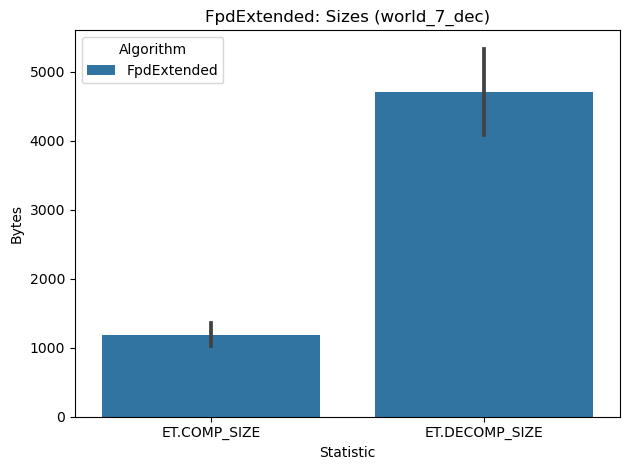

In [4]:
size_types = [ET.COMP_SIZE, ET.DECOMP_SIZE]
averages = df.copy()
averages.loc['mean'] = averages.mean(numeric_only=True)
averages = averages.iloc[-1]
sizes = averages[size_types]
print("Compression Ratio:", sizes[1] / sizes[0])

sizes = df[size_types]
sizes.columns = sizes.columns.map(str)
sizes['Algorithm'] = ALG.__class__.__name__

dataset_name = os.path.splitext(os.path.basename(DATASET_PATH))[0]
baseline_file = 'baseline_' + dataset_name + '.csv'
if os.path.exists(baseline_file):
    baseline = pd.read_csv(baseline_file)
    baseline['Algorithm'] = 'Baseline'
    sizes = pd.concat([sizes, baseline[[str(i) for i in size_types + ['Algorithm']]]])
else:
    baseline_file = None
sizes = sizes.melt('Algorithm', var_name="Statistic", value_name='Bytes')
sizes['Statistic'] = sizes['Statistic'].apply(lambda x: str(x))
sns.barplot(data=sizes, x="Statistic", y='Bytes', hue="Algorithm")
plt.ylabel('Bytes');
plt.title(ALG.__class__.__name__ + ": Sizes (" + dataset_name + ')');
plt.tight_layout()

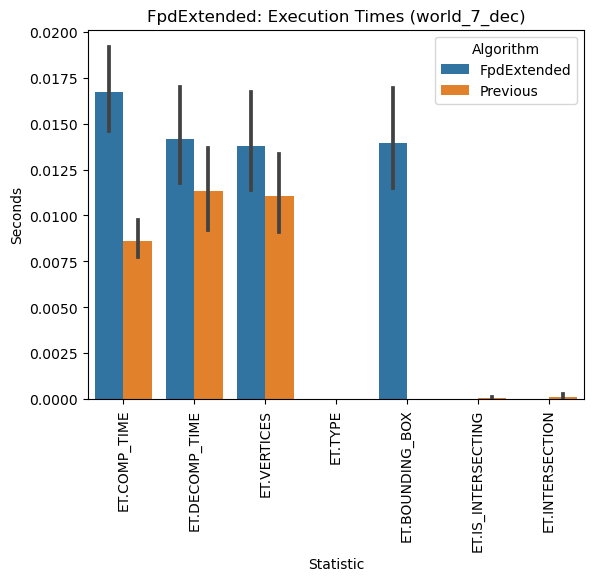

In [5]:
SHOW_PREVIOUS = True

times = df.drop(axis=1, labels=['idx_unary', 'idx_binary', ET.COMP_SIZE, ET.DECOMP_SIZE])
times['Algorithm'] = ALG.__class__.__name__

if baseline_file != None:
    baseline_times = baseline.drop(axis=1, labels=['idx_unary', 'idx_binary', 'ET.COMP_SIZE', 'ET.DECOMP_SIZE', 'Unnamed: 0'])
    times = pd.concat([times, baseline_times])

prevs = glob.glob(f'reports/{ALG.__class__.__name__}_{dataset_name}*')
if len(prevs) != 0 and SHOW_PREVIOUS:
    prev = pd.read_csv(prevs[-1])
    prev['Algorithm'] = 'Previous'
    prev_times = prev.drop(axis=1, labels=['idx_unary', 'idx_binary', 'ET.COMP_SIZE', 'ET.DECOMP_SIZE', 'Unnamed: 0'])
    times = pd.concat([times, prev_times])
    
times = times.melt('Algorithm', var_name="Statistic", value_name='Seconds')
times['Statistic'] = times['Statistic'].apply(lambda x: str(x))

sns.barplot(data=times, x="Statistic", y='Seconds', hue="Algorithm")

plt.xticks(rotation=90)
plt.ylabel('Seconds');
plt.title(ALG.__class__.__name__ + ": Execution Times (" + dataset_name + ')');

### Export to CSV

In [6]:
# Exports in the format: 2023-02-13_17:09:12_NoCompression.
df.to_csv("reports/" + ALG.__class__.__name__ + '_' + dataset_name + "_" + datetime.now().strftime("%Y-%m-%d_%H:%M:%S") + ".csv")
#df.to_csv("baseline_" + dataset_name + ".csv")

### Verify Integrity
Need to check that the operations are correct and that the decompression is lossless.

In [7]:
#raise BaseException("Avoiding Check!")
# Compress GeoJSON to Wkt. WKT is the source of truth

df_vals = pd.DataFrame(vals)
old_ALG = ALG
random.seed(SEED) # Reset random

# Validate the operations, i.e. verify that "results of the operations performed above" == "the results using no compression".
ALG = Wkb() # Alter global compression algorithm, used in 'measure()'
for i in tqdm.tqdm(range(len(df_vals))):
    r = df_vals.iloc[i]
    file_comp = f"{COMPR_PATH}/{r.idx_unary}"
    shp = shape(get_shape_data(r.idx_unary))
    # Is quantization done?
    if cfg.USE_FPINT:
        shp = shapely.from_wkt(shapely.to_wkt(shp, rounding_precision=7))
    # Compress to WKB
    compress(shp, file_comp)
    # Read binary into memory
    f = open(file_comp, "rb")
    bin = f.read()
    f.close()

    # Is decompressed file (from other algorithm) equal to original (compressed to WKT)?
    if not filecmp.cmp(file_comp, f"{DECOMPR_PATH}/{r.idx_unary}", shallow=False):
        print(file_comp)
        print(ALG.decompress(bin)[1])
        print(shapely.from_wkb(open(f"{DECOMPR_PATH}/{r.idx_unary}", 'rb').read()))
        assert(False)

    # The operations that are checked here (supported by "measure_unary"):
    unary_operations = [ET.VERTICES, ET.TYPE, ET.BOUNDING_BOX]
    for uop in unary_operations:
        v_no_compression = measure(uop, bin, value_only=True)
        diff = v_no_compression == r[uop]
        valid = diff if type(diff) != np.ndarray else diff.all()
        if not valid:
            print(uop, file_comp, v_no_compression, r[uop], sep='\n')
            assert(False)

    l_idx, r_idx = r.idx_binary
    l_shp = shape(get_shape_data(l_idx))
    r_shp = shape(get_shape_data(r_idx))
    # Is quantization done?
    if cfg.USE_FPINT:
        l_shp = shapely.from_wkt(shapely.to_wkt(l_shp, rounding_precision=7))
        r_shp = shapely.from_wkt(shapely.to_wkt(r_shp, rounding_precision=7))
    compress(l_shp, f"{COMPR_PATH}/{l_idx}")
    compress(r_shp, f"{COMPR_PATH}/{r_idx}")
    # Read both binary into memory
    f = open(f"{COMPR_PATH}/{l_idx}", "rb")
    l_bin = f.read()
    f.close()

    f = open(f"{COMPR_PATH}/{r_idx}", "rb")
    r_bin = f.read()
    f.close()

    if not (cfg.USE_ENTROPY or cfg.COMPRESS_CHUNK):
        # Add
        _, v = ALG.vertices(bin)
        add_idx = random.randint(0, len(v) - 2)
        add_point = (round(v[add_idx][0] + random.randint(-25, 25) * 0.00001, 7), round(v[add_idx][1] + random.randint(-25, 25) * 0.00001, 7))
        v_no_compression = measure(ET.ADD_VERTEX, (bin, add_idx, add_point), value_only=True)
        _, v_no_compression = ALG.decompress(v_no_compression)
        _, v_comp = old_ALG.decompress(r[ET.ADD_VERTEX])
        v_no_compression = shapely.to_wkt(v_no_compression)
        v_comp = shapely.to_wkt(v_comp)
        
        if not v_no_compression == v_comp:
            print(file_comp, add_idx, add_point, v_no_compression, v_comp, sep='\n')
            assert(False)
    
    # Binary operations
    # binary_operations = [ET.IS_INTERSECTING, ET.INTERSECTION]
    # for bop in binary_operations:
    #     v_no_compression = measure(bop, (l_bin, r_bin), value_only=True)
    #     diff = v_no_compression == r[bop]
    #     valid = diff if type(diff) != np.ndarray else diff.all()
        # Is now tested in separate notebook
        #if not valid:
            #print(bop, l_idx, r_idx)
            #assert(False)

ALG = old_ALG
print("PASSED")

100%|██████████| 1000/1000 [00:08<00:00, 122.08it/s]

PASSED
